In [85]:
import os
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel
from imblearn.over_sampling import SMOTE
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

### Extracting the Faearues and Target from the html file

In [86]:
def feature_extract(file_path):
    text_data = []
    with open(file_path,'r',encoding='utf-8') as file:
        #parsing the file using html parser
        soup = BeautifulSoup(file,'html.parser') 
        # finding the table elements
        tables = soup.find_all('table')
        for table in tables:
            rows = table.find_all('tr')     #table rows

            for row in rows:
                cells = row.find_all(['th','td'])   #table header and table data
                cell_text = ' '.join(cell.get_text(strip=True) for cell in cells)

                #removing all the characters other than alphabets and space
                text = re.sub(r'[^a-zA-Z\s]',' ', cell_text) 
                text_data.append(text)

    feature = ' '.join(text_data)
    feature = (re.sub(r'\s+',' ',feature)).lower() #substituting all the extra spaces with one white space
    return feature

In [87]:
def load_data(base_dir):
    data = []
    for class_name in os.listdir(base_dir):             #accessing the data folder
        class_path = os.path.join(base_dir,class_name)  #path to data/class_names
        if os.path.isdir(class_path):                   #if it is a directory then it will access the files inside it
            for file in os.listdir(class_path):         
                if file.endswith('.html'):              ##if it is a html file...
                    file_path = os.path.join(class_path,file)
                    
                    #extract the features using the previous function
                    text = feature_extract(file_path)
                    data.append((text,class_name))
    df = pd.DataFrame(data,columns=['Text','Class'])
    return df


In [88]:
# assigning base directory to the variable and call the function

base_dir = '/Users/velmurugan/Desktop/@/python_works/html finance classification model/data'
df = load_data(base_dir)

In [89]:
#defining colum_width, In order to view the entire exftracted feature 

pd.set_option('display.max_colwidth',None)
df

,Text,Class
0,cash flows from financing activities decrease increase of principal under capital leaseobligations net proceeds from short term borrowings repayment of short term borrowings proceeds from long term debt repayment of long term debt buyback of equity shares including transaction cost payment for deferred consideration on business acquisition proceeds from issuance of equity shares proceeds from subscription of shares pending allotment dividend paid excess tax benefit related to stock options exercise net cash used in financing activities effect of exchange rate changes on cash and cashequivalents net increase decrease in cash and cash equivalents cash and cash equivalents at the beginning of the year cash and cash equivalents at the end of the year supplemental disclosures of cash flow shares issued for consideration other than cash on acquisition of business of geometric limited property and equipment acquired under capital lease obligation cash payments for interest expenses cash payments for income taxes,Cash Flow
1,year ended st march year ended st march cash flow from operating activities profit before exceptional items and tax adjustments for share of net profit loss of associates and joint ventures accounted for using the equity method bad debts advances claims and deposits written off write back of provision for doubful debts provision for doubtful debts depreciation and amortisation expense apportioned government grants income net loss on disposal of property plant and equipment net loss on sale fair valuation of investments finance costs interest income dividend income provision no longer required operating profit before working capital changes adjustments for increase decrease in trade and other receivables increase decrease in inventories increase decrease in trade and other payables cash generated from operations direct taxes paid net of refunds cash flow before exceptional items exceptional items net net cash generated from operating activities a cash flow from investing activities purchase of property plant and equipment and intangible assets sale proceeds of property plant and equipment purchase of non current investments sale proceeds of non current investments net sale of current investments interest income received dividend income received net cash used in investing activities b,Cash Flow
2,particulars as on as on net profit before tax add depreciation add misc expenses add interest less interest received operating profit increase in inventories increase in debtors increase in loan advances increase decrease in current liabilities cash generated from operations less tax expense less interest paid cash from operations increase in investments add r d in process materials add additions to fixed assets add increase in capital work in progress add r d capital expenditure net cash used in investing receipts from share capital receipts from new borrowings net cash used financing activity net cash flow opening balance net cash flow cash and cash equivalents,Cash Flow
3,description year ended march year ended march a cash inflow outflow from operating activitiesprofit before taxadd less depreciationinterest incomeinterest expenseprofit on sale of fixed assetsoperating profit before working capital changesadjustment for inventoriestrade and other receivabletrade and other payablecash generated from operations before taxtax paid tax refund net cash inflow outflow from operating activities b cash inflow outflow from investing activitiesacquisition of fixed assets capital work in progress sale of fixed assetsinterest received net cash inflow outflow from investing activities c cash inflow outflow from financing activitiessecured loan repaymentof loaninterest paidunsecured loan net cash inflow outflow from financing activities net increase decrease in cash and cash equivalent a b c add cash and cash equivalent at the beginning of the yearcash and cash equivalent at the end of year,Cash Flow
4,inr in crores par

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2525 non-null   object
 1   Class   2525 non-null   object
dtypes: object(2)
memory usage: 39.6+ KB


### Word embedding using BERT Transformer and Label encoding

In [91]:
#Encoding the target variable
print(df['Class'].unique())

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

print(df['Class'].unique())

#defining independant and dependant variables
X = df['Text'].values
y = df['Class'].values

['Cash Flow' 'Income Statement' 'Balance Sheets' 'Others' 'Notes']
[1 2 0 4 3]


In [92]:
#To set the max len of tokenized sequemnce

text_split = (df['Text'].str.split(' '))
text_lengths = text_split.apply(len)
print(text_lengths[text_lengths > 500])

229     595
230     572
274     521
830     532
990     801
993     811
1210    635
1350    550
1382    718
1500    505
1568    596
Name: Text, dtype: int64


we have only few rows that have more than 500 words

In [93]:
#Importing the pretrained Bert tokenizer and model

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model =BertModel.from_pretrained('bert-base-uncased')

def embedding_text(text):
    #pytorch tensor of vector size 512
    inputs = tokenizer(text, return_tensors = 'pt',  truncation=True, padding=True, max_length=512)
    outputs = model(**inputs) #unpacks the inputs dictionary into keyword arguments
    
    # last hidden states are aggregated into single vector and detach from computational graph
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

In [94]:
X_embed = np.vstack([embedding_text(text) for text in X])

### Handling the imbalanced dataset

In [95]:
# splitting the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(
                                                    X_embed,
                                                    y,
                                                    test_size= 0.2,
                                                    random_state = 3
                                                  )
X_train.shape, y_train.shape

((2020, 768), (2020,))

In [96]:
#generates synthetic samples of minority class

smote = SMOTE(random_state= 3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,
                                                            y_train)

X_train_resampled.shape, y_train_resampled.shape

((4975, 768), (4975,))

### Training and Validating the classification model

In [97]:
#selecting the model
classifer_model = LogisticRegression(max_iter=500)

#fitting the model on training dataset
classifer_model.fit(X_train_resampled,y_train_resampled)

#predict the train and test data
train_pred = classifer_model.predict(X_train_resampled)
y_pred = classifer_model.predict(X_test)

#classification report for the predicted classes
train_metrics_report = classification_report(y_train_resampled,train_pred)
test_metrics_report = classification_report(y_test,y_pred)

print('Train Classification Report:','\n',train_metrics_report)
print('\n','Test Classification Report:','\n',test_metrics_report)


Train Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       995
           1       1.00      1.00      1.00       995
           2       1.00      1.00      1.00       995
           3       0.98      0.99      0.99       995
           4       0.99      0.97      0.98       995

    accuracy                           0.99      4975
   macro avg       0.99      0.99      0.99      4975
weighted avg       0.99      0.99      0.99      4975


 Test Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        61
           1       1.00      1.00      1.00         8
           2       0.95      0.95      0.95        57
           3       0.90      0.87      0.88       150
           4       0.90      0.93      0.92       229

    accuracy                           0.92       505
   macro avg       0.95      0.94      0.95       505
weighted avg  

Got 99% accuracy for Training samples and 92% accuracy for Test Samples

In [98]:
#saving the trained model using pickle

model_path = '/Users/velmurugan/Desktop/@/python_works/html finance classification model/Classifier.pkl'

with open(model_path,'wb') as f:
    pickle.dump(classifer_model,f)

In [99]:
#loading the saved model and check with random sample in the test dataset

with open(model_path,'rb') as f:
    classifer_model = pickle.load(f)

random_sample = np.random.randint(0,len(X_test))

y_pred = classifer_model.predict([X_test[random_sample]])

print('Ground Truth:',y_test[random_sample])
print('Predicted:',y_pred[0])

Ground Truth: 4
Predicted: 4


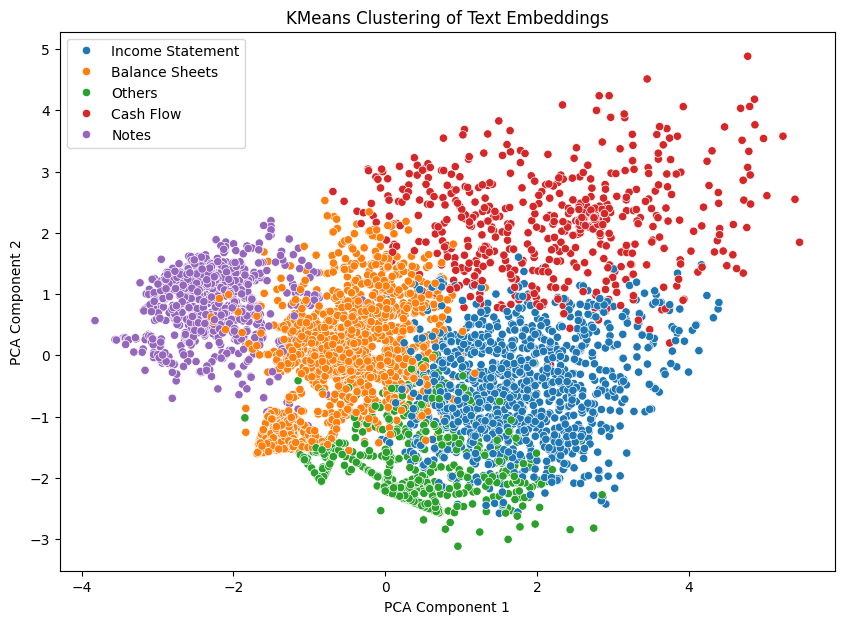

In [100]:
#Perform KMeans clustering on the embeddings to visualize patterns and insights

combined_data = np.vstack([X_train_resampled, X_test])

# Fit the KMeans model on the combined data and predict clusters
n_clusters = len(le.classes_)
kmeans = KMeans(n_clusters=n_clusters, random_state=3)
clusters = kmeans.fit_predict(combined_data)

# Perform PCA to reduce the combined data to 2 dimensions to visualize on 2d plane
pca = PCA(n_components=2)
combined_data_pca = pca.fit_transform(combined_data)

cluster_label = {1:'Cash Flow', 2:'Income Statement', 0:'Balance Sheets', 4:'Others', 3:'Notes'}
labelled_clusters = np.array([cluster_label[cluster] for cluster in clusters])


# Visualize the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=combined_data_pca[:, 0], y=combined_data_pca[:, 1], hue=labelled_clusters, palette='tab10')
plt.title('KMeans Clustering of Text Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()